# Kitobo Mini-Grid Electricity Demand Analysis
## Description and data
This notebook analyzes electricity consumption data from a mini-grid on Kitobo Island, Lake Victoria, Uganda, with the purpose of understanding how demand characteristics scale with the number of users. The mini-grid was constructed by New Sun Road, Public Benefit Corporation, and consumption data was made available to the UC Berkeley CAL-RAE research group under a research partnership. The consumption data comes from 34 electricity customers, mostly small businesses, with individual metered connections that measure power consumption, voltage, current, and power factor on a sub-minute time-scale. Before analysis, the data was aggregated onto different time scales of 5 seconds, 15 seconds, 1 minute, 5 minutes, 15 minutes, 1 hour, 1 day, 1 week, 1 month, and 1 year. The aggregation consists of representing all samples within the sampling period as a distribution parameterized by *mean, max, min, number of samples, and standard deviation*. Unless stated otherwise, it is assumed that we are using the mean value. There are gaps in the meter data due to communication outages, and these gaps could be significant. Unless stated otherwise, we use 1 month's data from January, 2016, which was selected because it had the smallest outage rate.

This work is copyrighted 2018, by Jonathan Lee. Please contact Jonathan at jtlee@berkeley.edu for questions or permission to use.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from AggregateStatisticCalculator import AggregateStatisticCalculator

## Load Factor
The first statistical metric we look at is load factor, which is the ratio of the mean power consumption to the maximum. Load factor is significant because some components in a power system are sized to meet peak demand, while others are sized in terms of average demand. For example, in a decentralized solar power system with battery storage, the capacity of the solar array is mostly determined by the average power demand, while inverter capacity is determined by the peak demand. Load factor is the quantity that relates the two. This translates to costs of components in a system: there are some costs that scale with the average power (\$/Wh), and some that scale with the peak power (\$/W). In general, a high load factor is a good thing because it means lower peak demand relative to average demand, so a high load factor will translate to lower \$/W costs. So we want to understand how load factor and associated costs are dependent on the number of users in a power system. It's generally known that because not everyone is likely to be using all of their appliances at the exact same time, that the load factor will be decreasing (technically non-increasing) with the number of users, but the question is how fast does it decrease and to what level?

To compute, we first initialize the statistic calculator for load factor (code available at https://github.com/cal-rae/electricity-demand-analysis) and download the pre-calculated sample statistics for each.

In [2]:
asc = AggregateStatisticCalculator('kitobo','minute','loadFactor')
asc.connect()
lfs = asc.getSamplesByNumberUsers()  # Get samples of load factor of aggregate profiles
totalStats = asc.getSamplesByNumberUsers(['avg', 'loadFactor'])  # Get sample statistics of aggregate profiles (min, max, cnt, avg)
asc.disconnect()

Because there are $N$ choose $k$ possible aggregate load profiles chosen from $N=34$ users, we get a *distribution* of load factor for each $k$ users. To show the distribution, we use a box and whisker density plot by number of users. Note how the load factor approaches an upper limit, and how the variation shrinks

<IPython.core.display.Javascript object>


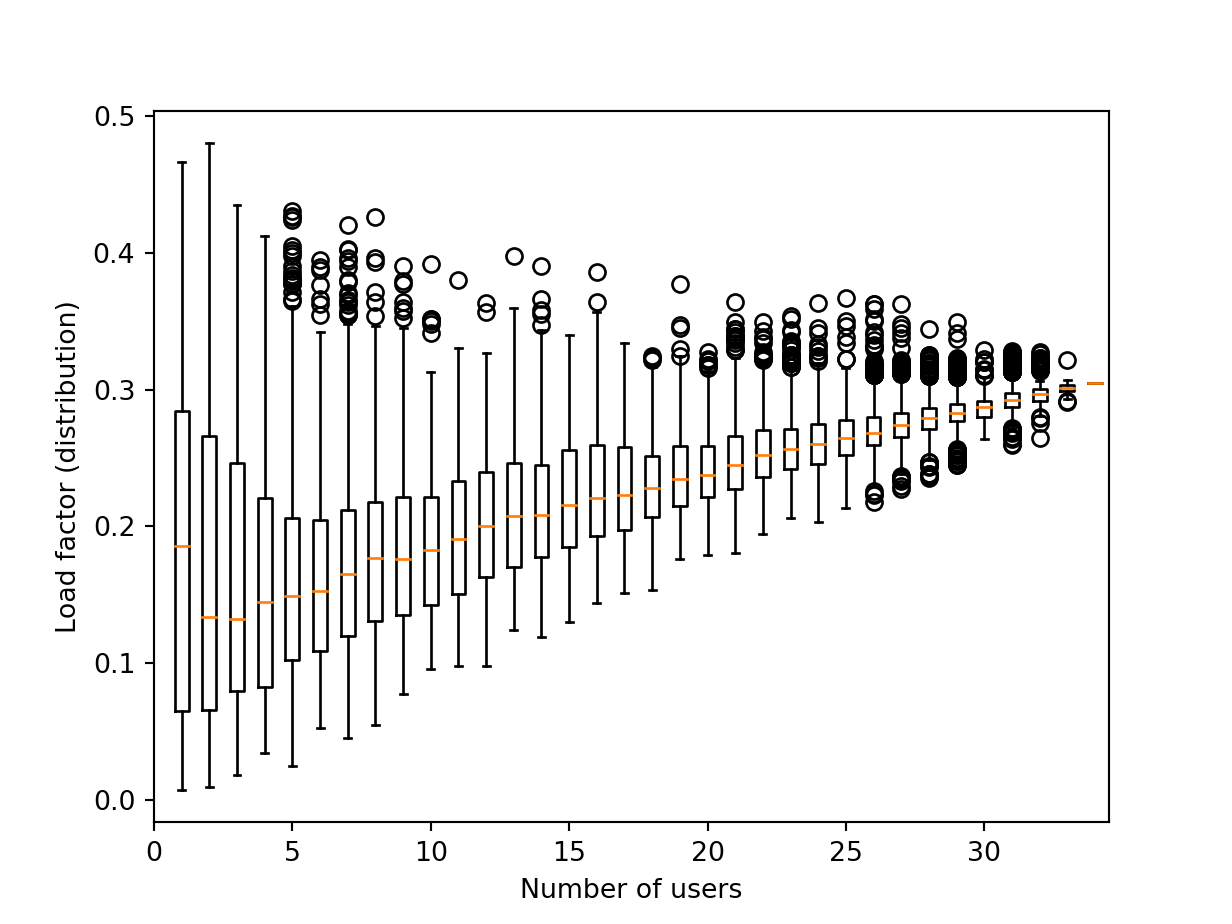

In [3]:
plt.figure()
plt.boxplot(lfs)
plt.xlabel('Number of users')
plt.ylabel('Load factor (distribution)')
plt.xticks(np.arange(0,len(lfs),5), np.arange(0,len(lfs),5));

For some context we can look at average vs peak consumption for each individual user below. See that most users consume low amounts of energy with low peak demand (bottom left). A couple users consume low energy, but have high peaks (top left) and some consume high energy with high peaks (top right). Note that no users consume high energy with low peaks (top right); i.e. there is no constant base load on the system.

<IPython.core.display.Javascript object>


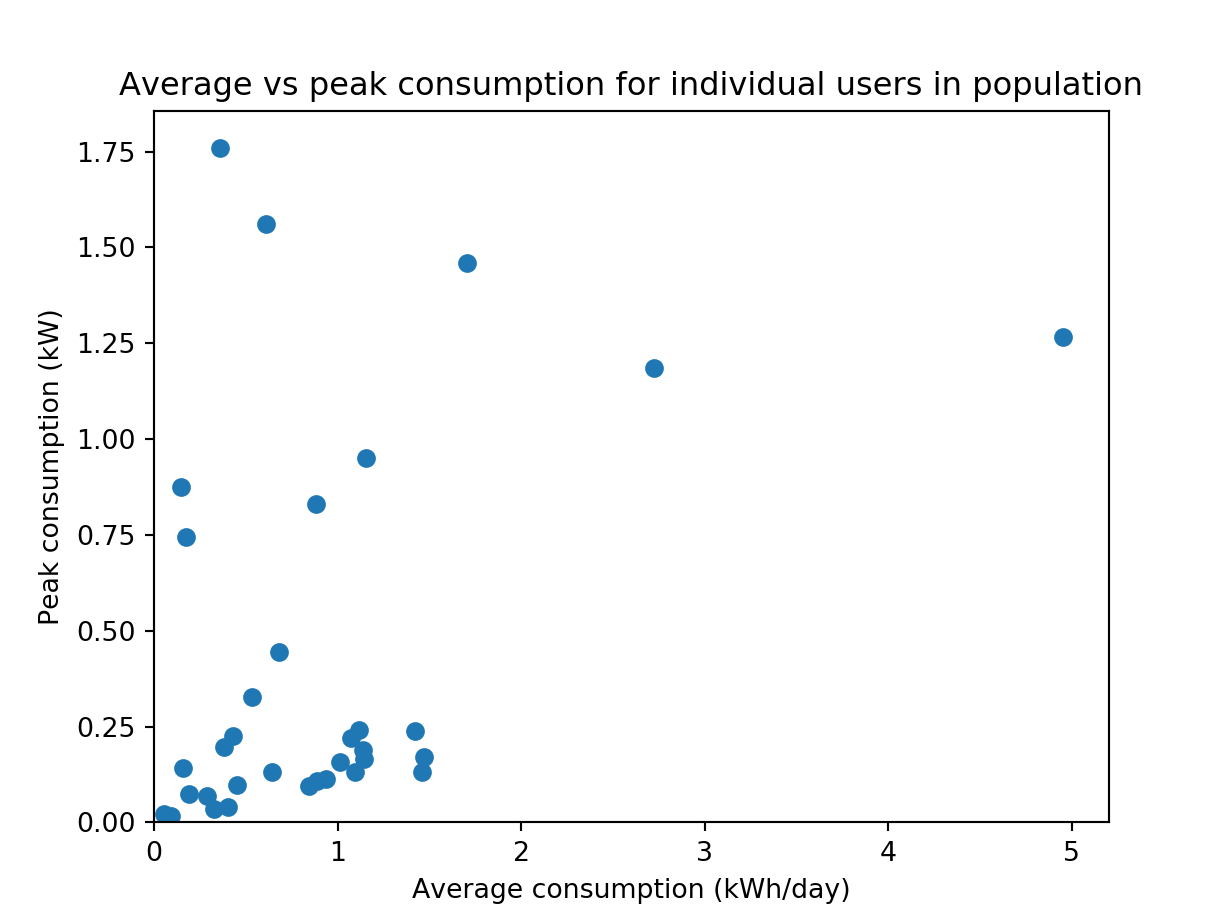

In [4]:
y = [t['avg']/t['loadFactor']/1000 for t in totalStats[0]]
x = [t['avg']*24/1000 for t in totalStats[0]]

plt.figure()
plt.scatter(x, y)
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
xmin, xmax = plt.xlim()
plt.xlim(0, xmax)
plt.xlabel('Average consumption (kWh/day)')
plt.ylabel('Peak consumption (kW)')
plt.title('Average vs peak consumption for individual users in population');

To illustrate the practical impact of load factor, we can look at the cost of a power supply; i.e. an inverter for an AC system. Assume the cost of a power supply is \$0.4 per watt and that are design target is to meet the peak capacity. We could have isolated systems where $k$ users share a supply that meets their aggregate peak demand and share the costs between them. Because $k$ aggregated users have a bigger load factor as $k$ increases (we saw this above), we expect that the average cost per user declines as $k$ gets bigger. We plot this below. See how the marginal savings to increasing $k$ decrease rather rapidly and are very small on average as $k$ gets beyond 10-15, but between 10 and 25 there is noticeable shrinking in the variance. The shrinking in variance is significant to a company that has to estimate load factor before recommending or selling a power system or that wants to design a standardized product.

<IPython.core.display.Javascript object>


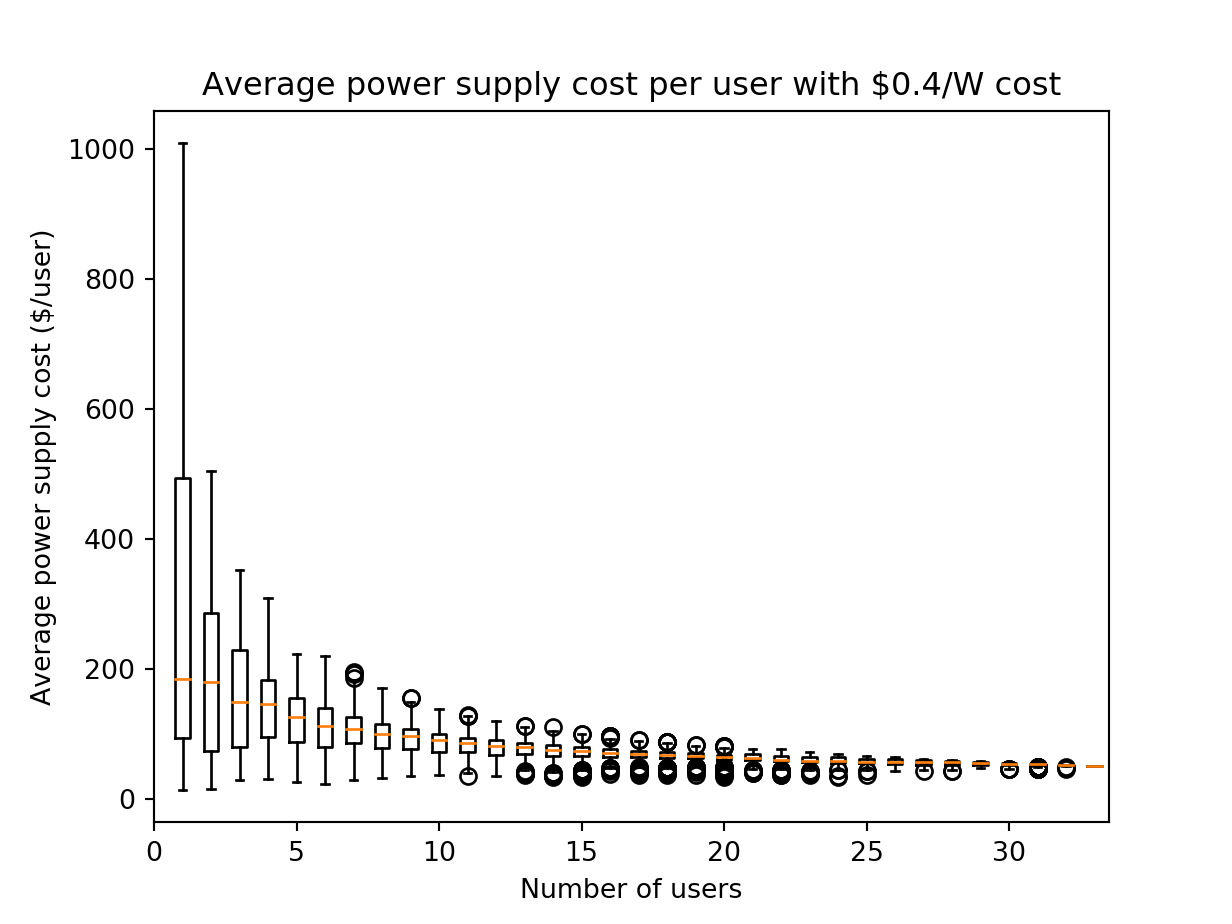

In [5]:
powerSupplyCost = 0.4 #$/W
cost = []
for k in range(1,len(totalStats)):
    costK = [x['avg']/x['loadFactor']*powerSupplyCost/k for x in totalStats[k]]
    cost.append(costK)

plt.figure()
plt.boxplot(cost)
plt.xlabel('Number of users')
plt.ylabel('Average power supply cost ($/user)')
plt.title('Average power supply cost per user with $' + str(powerSupplyCost) + '/W cost')
plt.xticks(np.arange(0,len(totalStats),5), np.arange(0,len(totalStats),5));

## Coefficient of varation
We can do a similar analysis for coefficient of variation in the load as a statistical parameter of general interest that relates to the predictability of load.

<IPython.core.display.Javascript object>


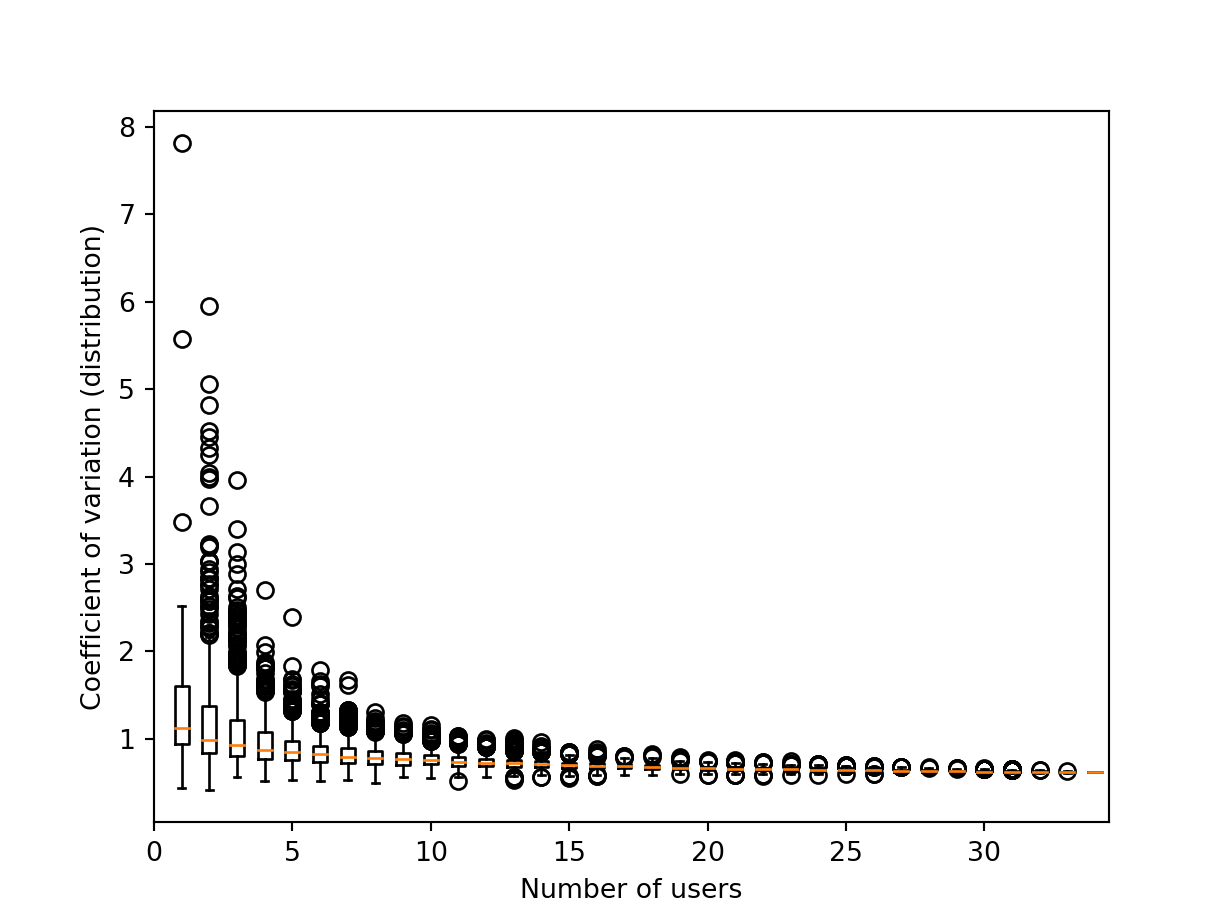

In [6]:
asc = AggregateStatisticCalculator('kitobo','minute','cov')
asc.connect()
covs = asc.getSamplesByNumberUsers()
asc.disconnect()
plt.figure()
plt.boxplot(covs)
plt.xlabel('Number of users')
plt.ylabel('Coefficient of variation (distribution)')
plt.xticks(np.arange(0,len(lfs),5), np.arange(0,len(lfs),5));

## Generalized load factor
By definition, the load factor gives the ratio of average load to maximum load. However, in designing systems with a reliability target, we might care only about ratio of average to a certain percentile. So, we repeat the load factor analysis, but with this more general metric. Note that load factor with respect to 100 percentile is equal to the standard load factor.

In [7]:
samplePercentiles = np.arange(55, 100, 10)
asc = AggregateStatisticCalculator('kitobo', 'minute', 'loadFactorPercentile', [samplePercentiles], maxIterations=100)
lfs = []
totalStats = []
asc.connect()
for ind, p in enumerate(samplePercentiles):
    lfs.append(asc.getSamplesByNumberUsers('loadFactor_{}'.format(p)))
    totalStats.append(asc.getSamplesByNumberUsers(['avg', 'loadFactor_{}'.format(p)]))

asc.disconnect()

# Append data for 100%; i.e. for standard load factor
asc = AggregateStatisticCalculator('kitobo','minute','loadFactor')
asc.connect()
samplePercentiles = np.append(samplePercentiles, 100)
lfs.append(asc.getSamplesByNumberUsers())
totalStats.append(asc.getSamplesByNumberUsers(['avg', 'loadFactor']))
asc.disconnect()


We can observe the statistical scaling relationship for each percentile. At first blush, it's difficult to see a pattern except the expected result that the asymptote of the factor drops with percentile.

<IPython.core.display.Javascript object>


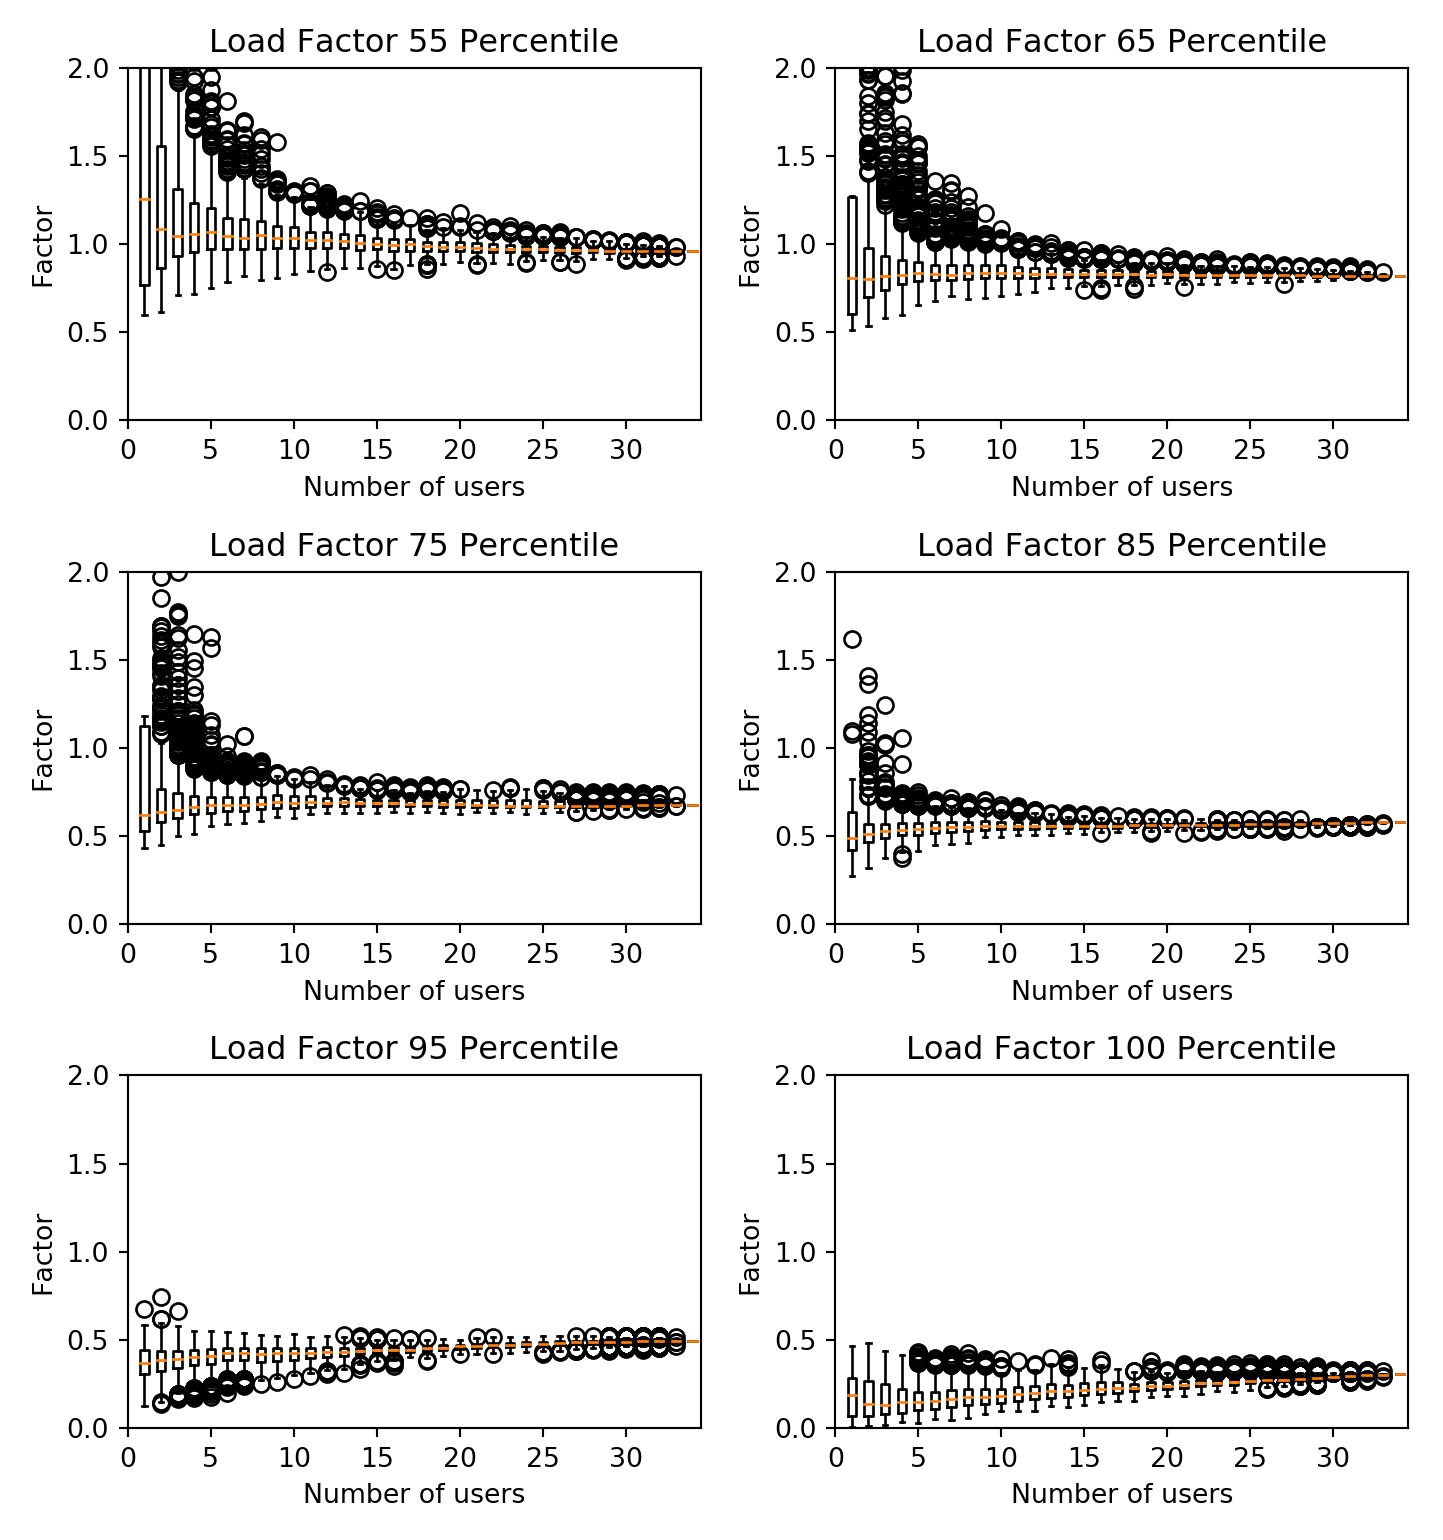

In [8]:
plt.figure(figsize=(7.5,8))

for ind, p in enumerate(samplePercentiles):
    plt.subplot(3, 2, ind+1)
    plt.boxplot(lfs[ind])
    plt.xlabel('Number of users')
    plt.ylabel('Factor'.format(p))
    plt.ylim(0, 2)
    plt.xticks(np.arange(0, len(lfs[ind]), 5), np.arange(0, len(lfs[ind]), 5));
    plt.title('Load Factor {} Percentile'.format(p));

plt.tight_layout()

To visualize a different way, we can put percentile on the x-axis, and the generalized factor on the y-axis, and plot a few lines for different aggregation levels (e.g. 5, 10, and 15).

<IPython.core.display.Javascript object>


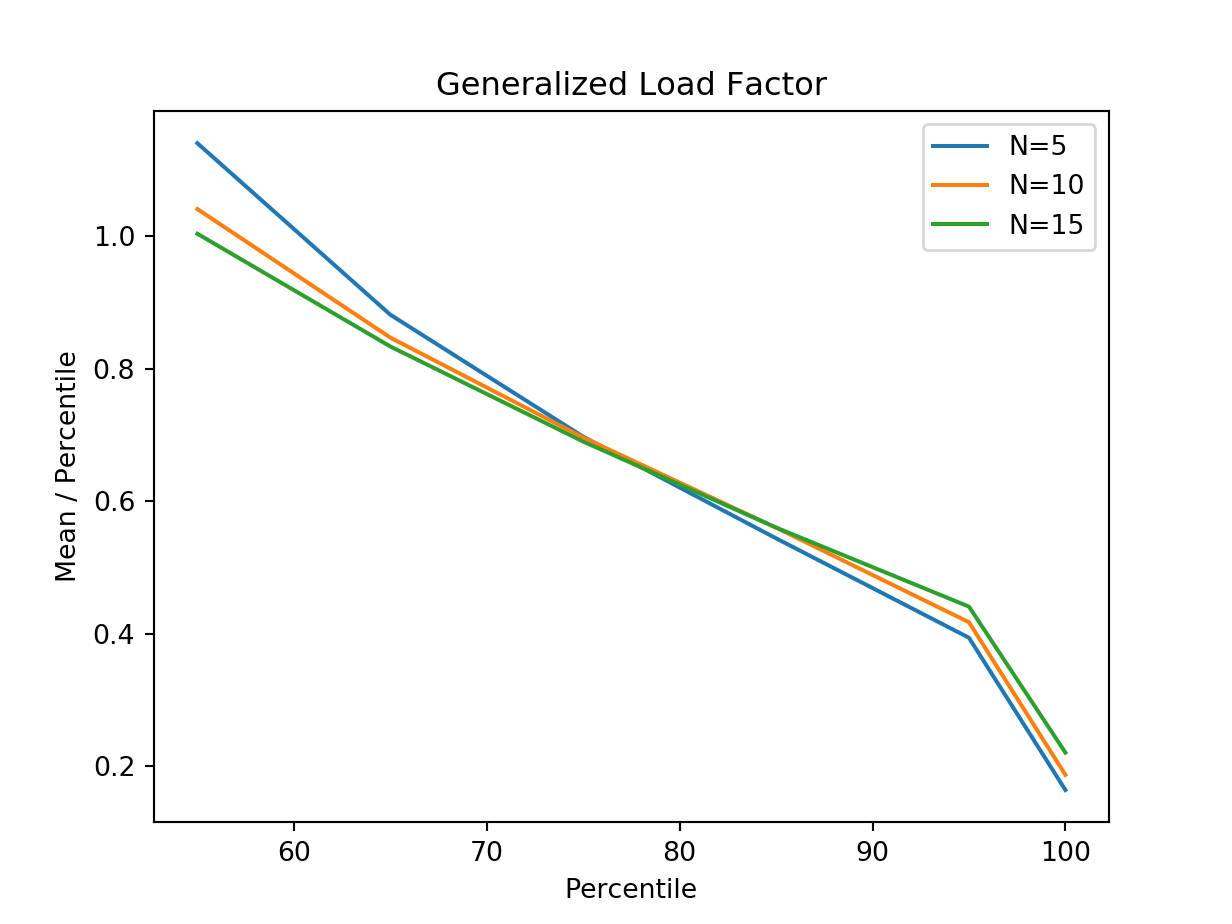

In [9]:
x = np.zeros(len(samplePercentiles))
y = np.zeros((3, len(samplePercentiles)))
for ind, p in enumerate(samplePercentiles):
    x[ind] = p
    for i in range(0,3):
        y[i, ind] = np.mean(lfs[ind][5*i+4])

plt.figure()
plt.plot(x, y.transpose())
plt.legend(['N=5', 'N=10', 'N=15'])
plt.title('Generalized Load Factor')
plt.xlabel('Percentile')
plt.ylabel('Mean / Percentile');
    

Recall how we calculated power supply cost per user above using a capacity cost of \$0.4 per watt when our target was to be able to provide peak capacity. Here, we do the same calculation, but instead of targeting to meet peak capacity, we meet the $x$ *percentile* of capacity. Note that this is different than the *percent* of capacity because it is the value at the x *percentile* of all samples of power consumption. Thus, designing for the $x$ percentile is a good measure of designing for the $x$ percent service availability index.

In particular, look at the difference between 95% and 100%. We see that going from 100% to 95% results in substantial savings, equivalent roughly on average to going from 1 to 5 users. So we see that increasing the target availability of the system increases the marginal savings of aggregating more users.

<IPython.core.display.Javascript object>


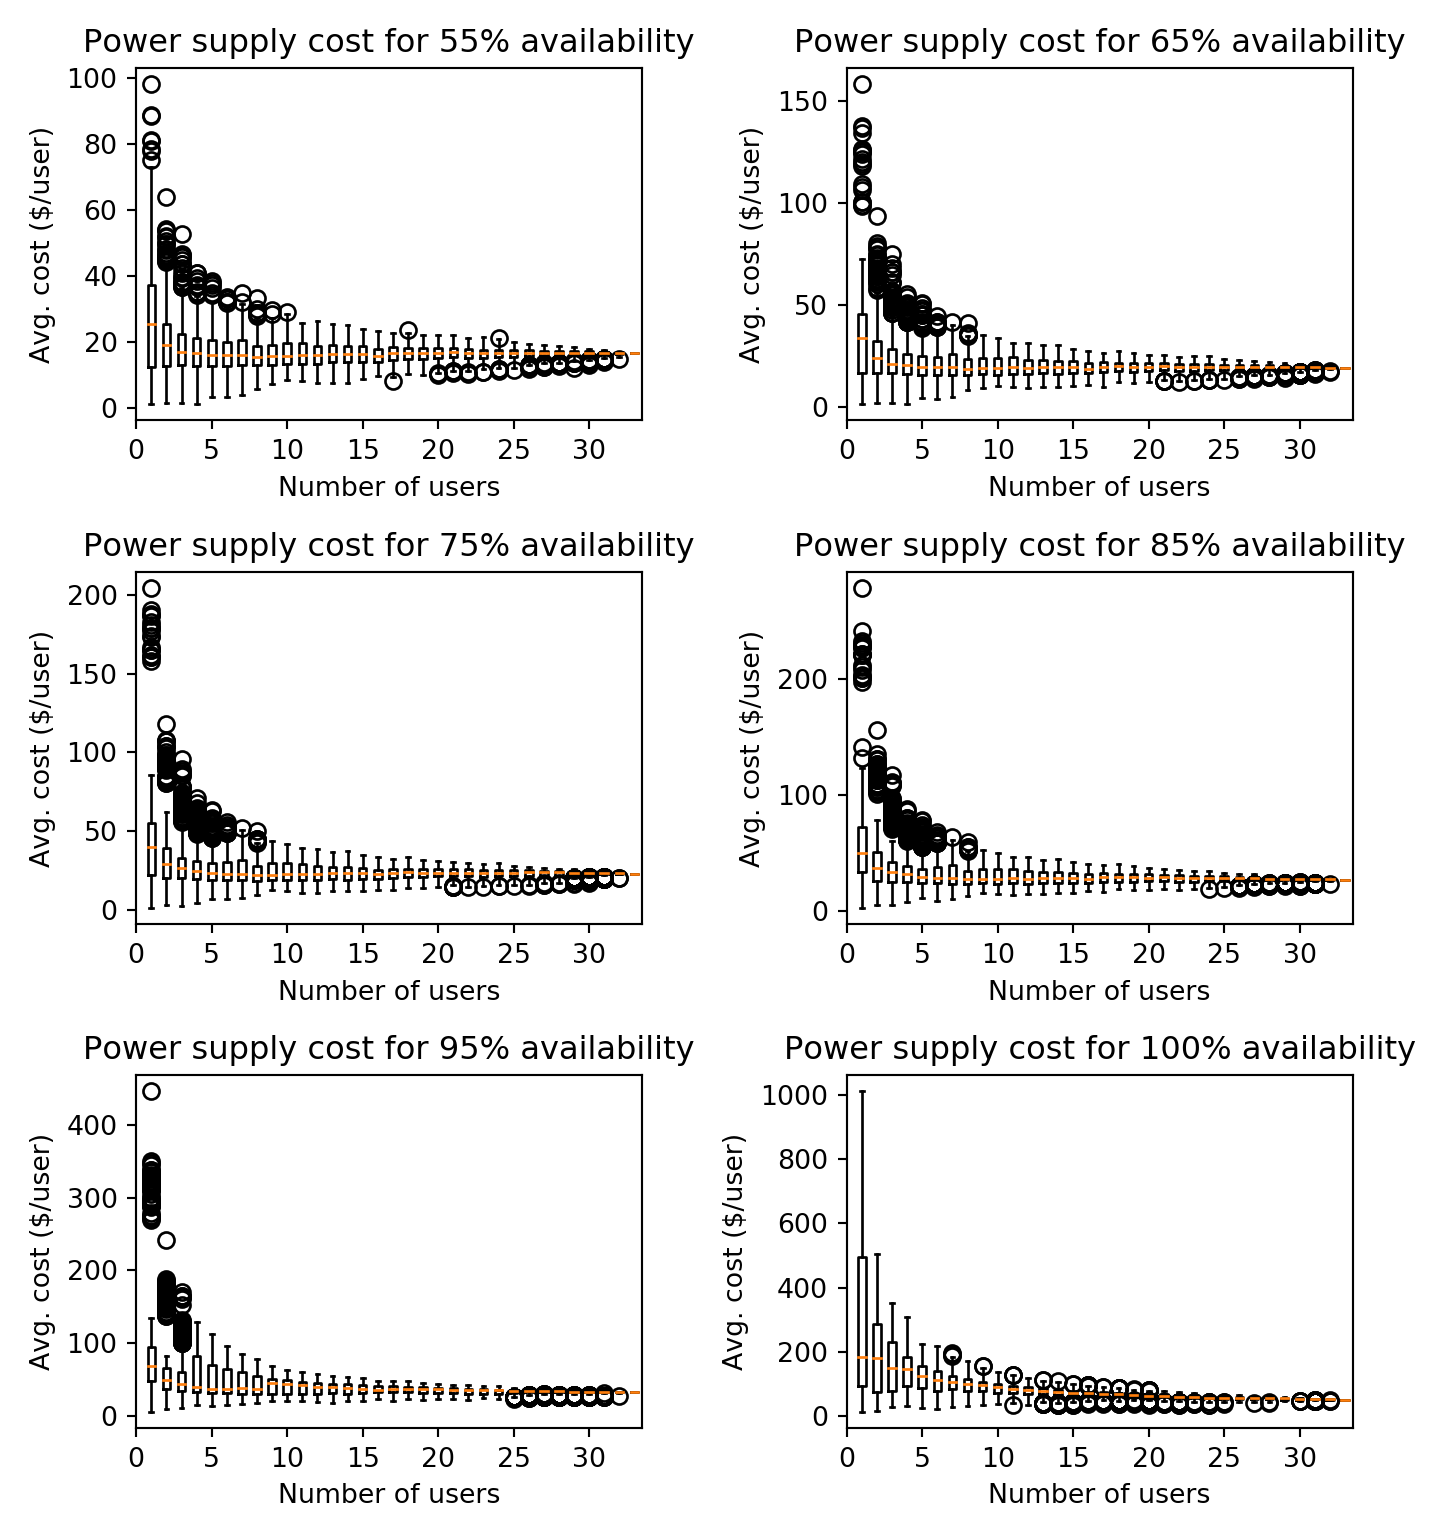

In [10]:
plt.figure(figsize=(7.5,8))

for ind, p in enumerate(samplePercentiles):
    cost = []
    for k in range(1,len(totalStats[ind])):
        if (p == 100):
            costK = [x['avg']/x['loadFactor']*powerSupplyCost/k for x in totalStats[ind][k]]
        else:
            costK = [x['avg']/x['loadFactor_{}'.format(p)]*powerSupplyCost/k for x in totalStats[ind][k]]
        cost.append(costK)

    plt.subplot(3, 2, ind+1)
    plt.boxplot(cost)
    plt.xlabel('Number of users')
    plt.ylabel('Avg. cost ($/user)'.format(p))
    plt.xticks(np.arange(0, len(lfs[ind]), 5), np.arange(0, len(lfs[ind]), 5));
    plt.title('Power supply cost for {}% availability'.format(p, powerSupplyCost));
    plt.xticks(np.arange(0,len(totalStats[ind]),5), np.arange(0,len(totalStats[ind]),5));

plt.tight_layout()